Toxicity Classification and minimization of unintended bias for Comments using Logistic Regression models.

**Azim Khan **

In [ ]:
#import required library
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

from sklearn import metrics

import time
import pickle 

import pandas as pd

In [ ]:
os.listdir("../")

['lib64',
 'dev',
 'lib',
 'opt',
 'var',
 'run',
 'sbin',
 'etc',
 'tmp',
 'sys',
 'usr',
 'home',
 'bin',
 'proc',
 'boot',
 'root',
 'mnt',
 'media',
 'srv',
 'content',
 '.dockerenv',
 'tools',
 'datalab',
 'python-apt',
 'lib32',
 'NGC-DL-CONTAINER-LICENSE']

In [ ]:

train = pd.read_csv('/content/drive/MyDrive/dataset/train.csv')
submission_TFIDF = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')

In [ ]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [ ]:
Data_EDA=pd.DataFrame({'target':(train['target'].values>=0.5).astype(bool).astype(np.int)})
Data_EDA["Labels"]=Data_EDA['target'].apply(lambda x:"Non Toxic" if x==0 else "Toxic" )
Data_EDA["comment_length"]=train['comment_text'].str.len()
Data_EDA["comment_text"]=train['comment_text']

<ipython-input-8-285652356c4c>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Data_EDA=pd.DataFrame({'target':(train['target'].values>=0.5).astype(bool).astype(np.int)})


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


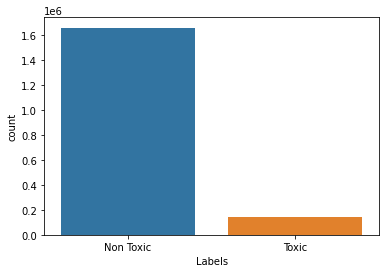

In [ ]:
sns.countplot(Data_EDA["Labels"])
#sns.countplot((train['target'].values<0.5).astype(bool).astype(np.int),label=["Toxic","Non Toxic"])

In [ ]:
print(len(train.comment_text[train['target'] >= 0.5]) /      len(train['comment_text']) * 100,'percent of toxic')
print(len(train.comment_text[train['target'] < 0.5]) / len(train['comment_text']) * 100,'percent of non toxic')

7.99690172277954 percent of toxic
92.00309827722046 percent of non toxic


In [ ]:
unique_qs = len(np.unique(train['comment_text']))
qs_morethan_onetime = np.sum(train['comment_text'].value_counts() > 1)

In [ ]:
unique_qs

1780823

In [ ]:
qs_morethan_onetime

10180

In [ ]:
train.duplicated(subset=set(train.columns)).value_counts()

False    1804874
dtype: int64

In [ ]:
train.isnull().sum()

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [ ]:
Data_EDA=pd.DataFrame({'target':(train['target'].values>=0.5).astype(bool).astype(np.int)})
Data_EDA["Labels"]=Data_EDA['target'].apply(lambda x:"Non Toxic" if x==0 else "Toxic" )
Data_EDA["comment_length"]=train['comment_text'].str.len()
Data_EDA["comment_text"]=train['comment_text']

<ipython-input-16-285652356c4c>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Data_EDA=pd.DataFrame({'target':(train['target'].values>=0.5).astype(bool).astype(np.int)})


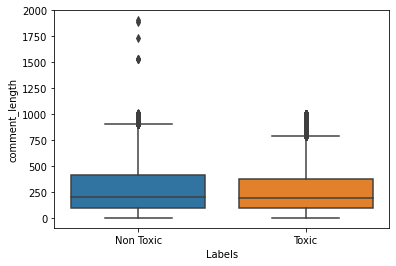

In [ ]:
ax = sns.boxplot(x="Labels", y="comment_length", data=Data_EDA)

In [ ]:
#looking for the percecntile values for toxic
for i in range(0,100,10):
    var =Data_EDA[Data_EDA["Labels"]=="Toxic"]["comment_length"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 3
10 percentile value is 52
20 percentile value is 83
30 percentile value is 115
40 percentile value is 151
50 percentile value is 195
60 percentile value is 250
70 percentile value is 324
80 percentile value is 436
90 percentile value is 652
100 percentile value is  1000


In [ ]:
#looking for the percecntile values for non toxic
for i in range(0,100,10):
    var =Data_EDA[Data_EDA["Labels"]=="Non Toxic"]["comment_length"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 1
10 percentile value is 47
20 percentile value is 77
30 percentile value is 111
40 percentile value is 152
50 percentile value is 203
60 percentile value is 269
70 percentile value is 358
80 percentile value is 496
90 percentile value is 755
100 percentile value is  1906


In [ ]:
Data_EDA_len=Data_EDA[Data_EDA["comment_length"]>1300]

In [ ]:
Data_EDA_len

,target,Labels,comment_length,comment_text
169,0,Non Toxic,1737,"Am I missing something, because there's nothin..."
248,0,Non Toxic,1906,"Predatory patrol towing isn't a big subject, a..."
401,0,Non Toxic,1535,"I'm not a big fan of either, but I've seen bot..."
1894,0,Non Toxic,1891,As usual WW plumbing the depths for deeper mea...
33197,0,Non Toxic,1535,"I'm not a big fan of either, but I've seen bot..."
88955,0,Non Toxic,1535,"I'm not a big fan of either, but I've seen bot..."
115884,0,Non Toxic,1535,"I'm not a big fan of either, but I've seen bot..."


In [ ]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import nltk
nltk.download('stopwords')  
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def wordDensity(text):
    text=re.sub('[.,!?;:()*&^%$#@_+\~\'"]', '', text)
    words=text.split()
    uniqueWords=set(words)
    density=[]
    if len(words)==0:
        return 0   
    for i in uniqueWords:       
        density.append(words.count(i)/len(words))   
    return sum(density)/len(density)  

In [ ]:
def numerical_features(df): 
    df['total_length'] = df['comment_text'].apply(len)
    df['capitals'] = df['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
    df['num_exclamation_marks'] = df['comment_text'].apply(lambda comment: comment.count('!'))
    df['num_question_marks'] = df['comment_text'].apply(lambda comment: comment.count('?'))
    df['num_punctuation'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
    df['num_symbols'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '@^$*&$%`#'))
    df['num_words'] = df['comment_text'].apply(lambda comment: len(comment.split()))
    df['num_unique_words'] = df['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    df['num_smilies'] = df['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))
    df['word_density'] = df['comment_text'].apply(wordDensity)
    df['num_stopWords']=df['comment_text'].apply(lambda comment: sum(1 for c in comment if c in stop_words))
    df['num_nonStopWords']=df['comment_text'].apply(lambda comment: sum(1 for c in comment if c not in stop_words))
    df['num_nonStopWords_density']=df.apply(lambda row: float(row['num_nonStopWords'])/(float(row['num_stopWords'])+float(row['num_nonStopWords'])),axis=1)
    df['num_stopWords_density']=df.apply(lambda row: float(row['num_stopWords'])/(float(row['num_stopWords'])+float(row['num_nonStopWords'])),axis=1)
    
    return df

In [ ]:
train["Labels"]=Data_EDA["Labels"]

In [ ]:
train=numerical_features(train)

In [ ]:
submission_TFIDF = numerical_features(submission_TFIDF)

In [ ]:
submission_TFIDF.head()

,id,comment_text,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_words,num_unique_words,words_vs_unique,num_smilies,word_density,num_stopWords,num_nonStopWords,num_nonStopWords_density,num_stopWords_density
0,7097320,[ Integrity means that you pay your debts.]\n\...,84,4,0.047619,0,1,1,0,15,15,1.000000,0,0.066667,36,48,0.571429,0.428571
1,7097321,This is malfeasance by the Administrator and t...,84,4,0.047619,1,0,1,0,14,13,0.928571,0,0.076923,36,48,0.571429,0.428571
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,198,8,0.040404,0,0,5,1,35,31,0.885714,0,0.032258,59,139,0.702020,0.297980
3,7097323,"Paul: Thank you for your kind words. I do, in...",993,31,0.031219,0,0,37,0,162,114,0.703704,0,0.009804,358,635,0.639476,0.360524
4,7097324,Sorry you missed high school. Eisenhower sent ...,345,18,0.052174,0,0,3,2,65,51,0.784615,0,0.020000,122,223,0.646377,0.353623


In [ ]:
train['num_stopWords_density']

0          0.376238
1          0.359649
2          0.372093
3          0.357143
4          0.333333
             ...   
1804869    0.345178
1804870    0.324324
1804871    0.333333
1804872    0.345404
1804873    0.365217
Name: num_stopWords_density, Length: 1804874, dtype: float64

In [ ]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,num_symbols,num_words,num_unique_words,words_vs_unique,num_smilies,word_density,num_stopWords,num_nonStopWords,num_nonStopWords_density,num_stopWords_density
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,19,19,1.000000,0,0.052632,38,63,0.623762,0.376238
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,22,22,1.000000,0,0.045455,41,73,0.640351,0.359649
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,16,16,1.000000,0,0.062500,32,54,0.627907,0.372093
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,17,16,0.941176,0,0.062500,30,54,0.642857,0.357143
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,0,8,8,1.000000,0,0.125000,12,24,0.666667,0.333333


In [ ]:
# proposed evalution matrix
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

In [ ]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
#get_final_metric(bias_metrics_df, calculate_overall_auc(X_test_TFIDF, MODEL_NAME))

In [ ]:
train_TFIDF = train.copy()#pd.read_csv('../input/train.csv')
#submission_TFIDF = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')

In [ ]:
submission_TFIDF.columns

Index(['id', 'comment_text', 'total_length', 'capitals', 'caps_vs_length',
       'num_exclamation_marks', 'num_question_marks', 'num_punctuation',
       'num_symbols', 'num_words', 'num_unique_words', 'words_vs_unique',
       'num_smilies', 'word_density', 'num_stopWords', 'num_nonStopWords',
       'num_nonStopWords_density', 'num_stopWords_density'],
      dtype='object')

In [ ]:
train_TFIDF.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count', 'Labels',
       'total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks',
       'num_question_marks', 'num_punctuation', 'num_symbols', 'num_words',
       'num_unique_words', 'words_vs_unique', 'num_smilies', 'word_densi

In [ ]:
submission_TFIDF.head()

,id,comment_text,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_words,num_unique_words,words_vs_unique,num_smilies,word_density,num_stopWords,num_nonStopWords,num_nonStopWords_density,num_stopWords_density
0,7097320,[ Integrity means that you pay your debts.]\n\...,84,4,0.047619,0,1,1,0,15,15,1.000000,0,0.066667,36,48,0.571429,0.428571
1,7097321,This is malfeasance by the Administrator and t...,84,4,0.047619,1,0,1,0,14,13,0.928571,0,0.076923,36,48,0.571429,0.428571
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,198,8,0.040404,0,0,5,1,35,31,0.885714,0,0.032258,59,139,0.702020,0.297980
3,7097323,"Paul: Thank you for your kind words. I do, in...",993,31,0.031219,0,0,37,0,162,114,0.703704,0,0.009804,358,635,0.639476,0.360524
4,7097324,Sorry you missed high school. Eisenhower sent ...,345,18,0.052174,0,0,3,2,65,51,0.784615,0,0.020000,122,223,0.646377,0.353623


In [ ]:
train_TFIDF['comment_text'] = train_TFIDF['comment_text'].astype(str) 
submission_TFIDF['comment_text'] = submission_TFIDF['comment_text'].astype(str) 
# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

TOXICITY_COLUMN = 'target' 

# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

train_TFIDF = convert_dataframe_to_bool(train_TFIDF) 

In [ ]:
train_TFIDF.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,num_symbols,num_words,num_unique_words,words_vs_unique,num_smilies,word_density,num_stopWords,num_nonStopWords,num_nonStopWords_density,num_stopWords_density
0,59848,False,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,19,19,1.000000,0,0.052632,38,63,0.623762,0.376238
1,59849,False,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,22,22,1.000000,0,0.045455,41,73,0.640351,0.359649
2,59852,False,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,16,16,1.000000,0,0.062500,32,54,0.627907,0.372093
3,59855,False,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,17,16,0.941176,0,0.062500,30,54,0.642857,0.357143
4,59856,True,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,0,8,8,1.000000,0,0.125000,12,24,0.666667,0.333333


In [ ]:
train_TFIDF_label=train_TFIDF["target"].copy()

In [ ]:
train_TFIDF.drop(columns="target",inplace=True)

In [ ]:
#train_TFIDF = pd.read_csv('./input/train.csv')

X_train_cv_TFIDF, X_test_TFIDF, y_train_cv_TFIDF, y_test_TFIDF = train_test_split(train_TFIDF,train_TFIDF_label, test_size = 0.2, random_state = 0)
#X_train_TFIDF, X_test_TFIDF, y_cv_TFIDF, y_cv_TFIDF = train_test_split(X_train_cv_TFIDF,y_train_cv_TFIDF, test_size = 0.2, random_state = 0)
X_train_cv_TFIDF.reset_index(inplace=True)
X_test_TFIDF.reset_index(inplace=True)

In [ ]:
numerical_cols=['total_length', 'capitals', 'num_exclamation_marks','num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words',\
         'num_symbols','word_density','num_stopWords','num_nonStopWords']

In [ ]:
from sklearn.preprocessing import StandardScaler

X= X_train_cv_TFIDF[numerical_cols]
sc=StandardScaler()
sc.fit_transform(X)
numerical_feature_train= sc.transform(X)

Y = X_test_TFIDF[numerical_cols]
sc=StandardScaler()
sc.fit_transform(Y)
numerical_feature_test = sc.transform(Y)



In [ ]:
Z=submission_TFIDF[numerical_cols]
sc=StandardScaler()
sc.fit_transform(Z)
numerical_submission_TFIDF = sc.transform(Z)

In [ ]:
numerical_feature_train.shape

(1443899, 11)

In [ ]:
numerical_feature_test.shape

(360975, 11)

In [ ]:
numerical_submission_TFIDF.shape

(97320, 11)

In [ ]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import nltk
import re 

nltk.download('wordnet')
stop_words = set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def preprocessingText(text):
    
    words=word_tokenize(text)
    
    wordsWihoutStopwords=[lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    
    text=" ".join(wordsWihoutStopwords)
    
    text=re.sub(r"[^A-Za-z\?\@\^\$\%\`\'\#\:\-\)\(\)\;\.\,\&\!]"," ",text)
    text=re.sub(r"\s+"," ",text)
    
    return text

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
 import nltk
nltk.download('punkt')

X_train_cv_TFIDF["comment_text"]=X_train_cv_TFIDF["comment_text"].apply(preprocessingText)
X_test_TFIDF["comment_text"]=X_test_TFIDF["comment_text"].apply(preprocessingText)
submission_TFIDF["comment_text"]=submission_TFIDF["comment_text"].apply(preprocessingText)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
X_train_cv_TFIDF["comment_text"][0]

" bad season make forget national championship game appearance , conference championship , double digit win season row ? agree new staff even better , n't mean previous one sucked , ca n't still appreciate helped ."

In [ ]:
preprocessingText(X_train_cv_TFIDF["comment_text"][0])

"bad season make forget national championship game appearance , conference championship , double digit win season row ? agree new staff even better , n't mean previous one sucked , ca n't still appreciate helped ."

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000,ngram_range=(1,2))
X_tfidf_train = vectorizer.fit_transform(X_train_cv_TFIDF["comment_text"])

print(vectorizer.get_feature_names()[:25])

['aa', 'ab', 'abandon', 'abandoned', 'abc', 'abide', 'abiding', 'abiding citizen', 'ability', 'able', 'able afford', 'able get', 'abolish', 'aboriginal', 'abortion', 'about', 'abraham', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'absolutely correct', 'absolutely nothing', 'absolutely right']


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
scores = zip(vectorizer.get_feature_names(),\
                 np.asarray(X_tfidf_train.sum(axis=0)).ravel())
    
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)


In [ ]:
sorted_scores[-10:]

[('statehood', 96.21647963187662),
 ('equitable', 95.60868361265437),
 ('carbon dioxide', 95.46106291119037),
 ('kwh', 92.87434517709082),
 ('let look', 92.43123402527998),
 ('lastly', 90.82041968639601),
 ('dnr', 88.9628151944426),
 ('ly', 86.29311242403318),
 ('massengill', 85.87999285635958),
 ('hugh massengill', 84.18465629665893)]

In [ ]:
lowTfidfWords=[]
for key,value in dict(sorted_scores).items():
    if value<=150:
        lowTfidfWords.append(key)

In [ ]:
len(set(lowTfidfWords))

2120

In [ ]:
def preProcessingBasedOnTfidfScore(text):
    
    words=word_tokenize(text)
    
    wordsWihoutStopwords=[word for word in words if word.lower() not in lowTfidfWords]
    
    text=" ".join(wordsWihoutStopwords)
   
    return text

In [ ]:
X_train_cv_TFIDF["comment_text"]=X_train_cv_TFIDF["comment_text"].apply(preProcessingBasedOnTfidfScore)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000,ngram_range=(1,2))
X_tfidf_train = vectorizer.fit_transform(X_train_cv_TFIDF["comment_text"])
X_tfidf_test = vectorizer.transform(X_test_TFIDF["comment_text"])
submission_test_tfidf=vectorizer.transform(submission_TFIDF["comment_text"])

print("Shape of Train data: {}".format(X_tfidf_train.shape))
print("Shape of Test data: {}".format(X_tfidf_test.shape))      
print("Shape of Test data: {}".format(submission_test_tfidf.shape))   

Shape of Train data: (1443899, 10000)
Shape of Test data: (360975, 10000)
Shape of Test data: (97320, 10000)


In [ ]:
from scipy.sparse import hstack

X_train = hstack((X_tfidf_train,numerical_feature_train))
X_test = hstack((X_tfidf_test,numerical_feature_test))
X_submission = hstack((submission_test_tfidf,numerical_submission_TFIDF))

In [ ]:
X_train.shape

(1443899, 10011)

In [ ]:
X_test.shape

(360975, 10011)

In [ ]:
numerical_submission_TFIDF.shape

(97320, 11)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import linear_model

In [ ]:
y_train_cv_TFIDF

1072905    False
659482     False
289250      True
497151     False
1757082    False
           ...  
152315     False
963395     False
117952     False
1484405    False
305711     False
Name: target, Length: 1443899, dtype: bool

In [ ]:
X_train.shape

(1443899, 10011)

In [ ]:
#loggistic_regression
parameters = {'alpha': [0.01,0.1,10,1000,10**-14, 10**-12, 10**-10, 10**-8, 10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]}
log_reg = linear_model.SGDClassifier(loss="log",n_jobs=-1,class_weight='balanced')
grid_search = GridSearchCV(log_reg, parameters,cv=4)
grid_search.fit(X_train, y_train_cv_TFIDF)

GridSearchCV(cv=4,
             estimator=SGDClassifier(class_weight='balanced', loss='log',
                                     n_jobs=-1),
             param_grid={'alpha': [0.01, 0.1, 10, 1000, 1e-14, 1e-12, 1e-10,
                                   1e-08, 1e-06, 0.0001, 0.01, 1, 100, 10000,
                                   1000000]})

In [ ]:
grid_search.best_estimator_

SGDClassifier(alpha=10000, class_weight='balanced', loss='log', n_jobs=-1)

In [ ]:
log_reg=grid_search.best_estimator_
log_reg.fit(X_train, y_train_cv_TFIDF)
sig_clf = CalibratedClassifierCV(log_reg, method="sigmoid")
sig_clf.fit(X_train, y_train_cv_TFIDF)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=10000,
                                                    class_weight='balanced',
                                                    loss='log', n_jobs=-1))

In [ ]:
predict_y = sig_clf.predict_proba(X_test)

In [ ]:
MODEL_NAME = 'tfidf_Log_reg'
X_test_TFIDF[MODEL_NAME] = list(predict_y[:,1])

In [ ]:
X_test_TFIDF.head()

,index,id,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,num_words,num_unique_words,words_vs_unique,num_smilies,word_density,num_stopWords,num_nonStopWords,num_nonStopWords_density,num_stopWords_density,tfidf_Log_reg
0,546354,911573,hour student learning time classroom time stu...,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,...,65,55,0.846154,0,0.018519,138,245,0.639687,0.360313,0.074989
1,412488,748010,think author absolutely correct say two-state ...,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,...,58,51,0.879310,0,0.019608,121,203,0.626543,0.373457,0.077384
2,796018,5094769,know qur'an written waaay back saudi arabia do...,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,...,63,54,0.857143,0,0.019231,131,186,0.586751,0.413249,0.076879
3,922266,5247850,jt 's sun starting set shallowness becoming ev...,0.0,0.0,0.0,0.166667,0.0,NaN,NaN,...,14,12,0.857143,0,0.083333,33,41,0.554054,0.445946,0.087477
4,1711194,6220033,"elite , democrat republican , tried grease tru...",0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,12,11,0.916667,0,0.090909,26,53,0.670886,0.329114,0.087364


In [ ]:
# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
TOXICITY_COLUMN = 'target'

In [ ]:
X_test_TFIDF['target']=list(y_test_TFIDF)

In [ ]:
bias_metrics_df = compute_bias_metrics_for_model(X_test_TFIDF, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
0,male,8933,0.562815,0.680135,0.415599
1,female,10688,0.570536,0.712086,0.393487
3,christian,8099,0.601113,0.747585,0.371347
5,muslim,4224,0.601722,0.719484,0.410967
7,white,4989,0.607731,0.712892,0.428419
4,jewish,1517,0.624996,0.764993,0.395505
6,black,3057,0.635571,0.758237,0.409592
2,homosexual_gay_or_lesbian,2187,0.648748,0.753139,0.418747
8,psychiatric_or_mental_illness,999,0.687541,0.714365,0.496923


In [ ]:
Log_re_model=get_final_metric(bias_metrics_df, calculate_overall_auc(X_test_TFIDF, MODEL_NAME))
Log_re_model

0.5702368116604069